In [1]:
from __future__ import print_function

import sys
import os

#sys.path.append('UrbanCNN/');
#sys.path.append('srimmele/');
#sys.path.append('ecbm4040/');

from matplotlib.pyplot import imshow, plot, title


from srimmele.data_utils import getCityImages
from UrbanCNN.utils import generator_from_file

# these magics ensure that external modules that are modified are also automatically reloaded
%load_ext autoreload
%autoreload 2
%matplotlib inline


In [2]:
city = 'berlin, de'
if not os.path.exists('imagery/' + city):
    getCityImages(city)
else:
    print ('Image files already extracted')

Image files already extracted


[Image augmentation in original paper](https://github.com/adrianalbert/urban-environments/blob/master/land-use-classification/Finetuning%20on%20Urban%20Atlas%20data.ipynb)

In [3]:
all_classes = '''Agricultural + Semi-natural areas + Wetlands
Airports
Construction sites
Continuous Urban Fabric (S.L. > 80%)
Discontinuous Dense Urban Fabric (S.L. : 50% -  80%)
Discontinuous Low Density Urban Fabric (S.L. : 10% - 30%)
Discontinuous Medium Density Urban Fabric (S.L. : 30% - 50%)
Discontinuous Very Low Density Urban Fabric (S.L. < 10%)
Fast transit roads and associated land
Forests
Green urban areas
Industrial, commercial, public, military and private units
Isolated Structures
Land without current use
Mineral extraction and dump sites
Other roads and associated land
Port areas
Railways and associated land
Sports and leisure facilities
Water bodies'''.split("\n")

classes = all_classes
print(len(classes))

class2label = {c:i for i,c in enumerate(classes)}
label2class = {i:c for i,c in enumerate(classes)}
class_weights = {c:1 for c in label2class.keys()}

20


In [4]:
from keras.preprocessing.image import ImageDataGenerator


#this is the augmentation configuration the author's use for training
train_augmenter = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.10,
        zoom_range=[1,1.2],
        vertical_flip=True,
        rotation_range=15,
        horizontal_flip=True)

test_augmenter = ImageDataGenerator(rescale=1./255)

Using TensorFlow backend.


In [46]:
train_generator     = generator_from_file('data/train.csv', image_generator= train_augmenter, balance=1, \
                            batch_size = 100, seed=26, new_img_shape= (224,224), \
                            class_dict=None, shuffle=True, channels="RGB",
                            downsample=False, crop=42, batch_type = 'training', one_hot = False)

validation_generator = generator_from_file('data/train.csv', image_generator= test_augmenter, balance=1, \
                        batch_size = 100, seed=26, new_img_shape= (224,224), \
                        class_dict=None, shuffle=True, channels="RGB",
                        downsample=False, crop = 42, batch_type = 'validation', one_hot = False)


19601 total records


/home/ecbm4040/miniconda2/envs/dlenv/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


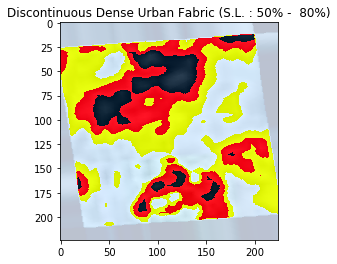

In [47]:
test = next(train_generator)
image =imshow(test[0][0,:,:,:])
test[1][0]
title(label2class[test[1][1]])


2827 total records


/home/ecbm4040/miniconda2/envs/dlenv/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


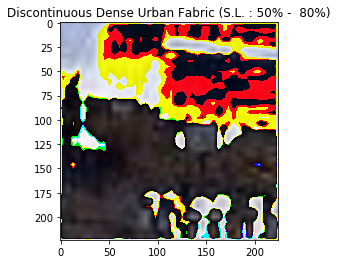

In [48]:
test = next(validation_generator)
image =imshow(test[0][0,:,:,:])
title(label2class[test[1][1]])


In [49]:
conv_feat_dict = {}

conv_feat_dict[0] = [64 , 64]
conv_feat_dict[1] = [128 , 128]
conv_feat_dict[2] = [256 ,256, 256]
conv_feat_dict[3] = [512 , 512, 512]
conv_feat_dict[4] = [512 , 512, 512]

conv_kernel_dict = dict(keys = conv_feat_dict.keys())

conv_kernel_dict[0] = [3] * 2
conv_kernel_dict[1] = [3] * 2
conv_kernel_dict[2] = [3] * 3
conv_kernel_dict[3] = [3] * 3
conv_kernel_dict[4] = [3] * 3

pooling_size_dict = dict(keys = conv_feat_dict.keys())

pooling_size_dict[0] = [2] * 2
pooling_size_dict[1] = [2] * 2
pooling_size_dict[2] = [2] * 3
pooling_size_dict[3] = [2] * 3 
pooling_size_dict[4] = [2] * 3

fc_units = [2048, 2048]


In [50]:
import tensorflow as tf
from srimmele.classifiers import training

tf.reset_default_graph()

training(train_generator, validation_generator,
             conv_feat_dict = conv_feat_dict,
             fc_units = fc_units,
             conv_kernel_dict = conv_kernel_dict,
             pooling_size_dict = pooling_size_dict,
             img_size = 224,
             l2_norm=0,
             seed=26,
             learning_rate=0.1,
             lr_decay = 2.0,
             epoch=20,
             samples_per_epoch = 2000,
             verbose=False,
             pre_trained_model=None)

epoch 1 


/home/ecbm4040/miniconda2/envs/dlenv/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


ResourceExhaustedError: OOM when allocating tensor with shape[100,64,112,112]
	 [[Node: train_step/gradients/max_pooling/MaxPool_grad/MaxPoolGrad = MaxPoolGrad[T=DT_FLOAT, data_format="NHWC", ksize=[1, 2, 2, 1], padding="SAME", strides=[1, 2, 2, 1], _device="/job:localhost/replica:0/task:0/gpu:0"](conv_layer_1/Relu, max_pooling/MaxPool, train_step/gradients/conv_layer_3/Conv2D_grad/tuple/control_dependency)]]

Caused by op 'train_step/gradients/max_pooling/MaxPool_grad/MaxPoolGrad', defined at:
  File "/home/ecbm4040/miniconda2/envs/dlenv/lib/python3.5/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/ecbm4040/miniconda2/envs/dlenv/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/ecbm4040/miniconda2/envs/dlenv/lib/python3.5/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/ecbm4040/miniconda2/envs/dlenv/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/ecbm4040/miniconda2/envs/dlenv/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/home/ecbm4040/miniconda2/envs/dlenv/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/ecbm4040/miniconda2/envs/dlenv/lib/python3.5/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/home/ecbm4040/miniconda2/envs/dlenv/lib/python3.5/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/ecbm4040/miniconda2/envs/dlenv/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/ecbm4040/miniconda2/envs/dlenv/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/ecbm4040/miniconda2/envs/dlenv/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/ecbm4040/miniconda2/envs/dlenv/lib/python3.5/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/ecbm4040/miniconda2/envs/dlenv/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/ecbm4040/miniconda2/envs/dlenv/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/ecbm4040/miniconda2/envs/dlenv/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/ecbm4040/miniconda2/envs/dlenv/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/ecbm4040/miniconda2/envs/dlenv/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/ecbm4040/miniconda2/envs/dlenv/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2698, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/ecbm4040/miniconda2/envs/dlenv/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2808, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/ecbm4040/miniconda2/envs/dlenv/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-50-5278e6807683>", line 19, in <module>
    pre_trained_model=None)
  File "/home/ecbm4040/ecbm4040-finalproject/srimmele/classifiers.py", line 215, in training
    step = train_step(loss)
  File "/home/ecbm4040/ecbm4040-finalproject/srimmele/classifiers.py", line 154, in train_step
    step = tf.train.AdadeltaOptimizer(learning_rate).minimize(loss)
  File "/home/ecbm4040/.local/lib/python3.5/site-packages/tensorflow/python/training/optimizer.py", line 315, in minimize
    grad_loss=grad_loss)
  File "/home/ecbm4040/.local/lib/python3.5/site-packages/tensorflow/python/training/optimizer.py", line 386, in compute_gradients
    colocate_gradients_with_ops=colocate_gradients_with_ops)
  File "/home/ecbm4040/.local/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py", line 542, in gradients
    grad_scope, op, func_call, lambda: grad_fn(op, *out_grads))
  File "/home/ecbm4040/.local/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py", line 348, in _MaybeCompile
    return grad_fn()  # Exit early
  File "/home/ecbm4040/.local/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py", line 542, in <lambda>
    grad_scope, op, func_call, lambda: grad_fn(op, *out_grads))
  File "/home/ecbm4040/.local/lib/python3.5/site-packages/tensorflow/python/ops/nn_grad.py", line 526, in _MaxPoolGrad
    data_format=op.get_attr("data_format"))
  File "/home/ecbm4040/.local/lib/python3.5/site-packages/tensorflow/python/ops/gen_nn_ops.py", line 1752, in _max_pool_grad
    data_format=data_format, name=name)
  File "/home/ecbm4040/.local/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "/home/ecbm4040/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2630, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/ecbm4040/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1204, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

...which was originally created as op 'max_pooling/MaxPool', defined at:
  File "/home/ecbm4040/miniconda2/envs/dlenv/lib/python3.5/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
[elided 19 identical lines from previous traceback]
  File "<ipython-input-50-5278e6807683>", line 19, in <module>
    pre_trained_model=None)
  File "/home/ecbm4040/ecbm4040-finalproject/srimmele/classifiers.py", line 208, in training
    seed=seed)
  File "/home/ecbm4040/ecbm4040-finalproject/srimmele/classifiers.py", line 51, in VGG16
    pooling_size = pooling_size_dict[0], seed = 26 , indexer = indexer)
  File "/home/ecbm4040/ecbm4040-finalproject/srimmele/classifiers.py", line 35, in __init__
    padding="SAME"))
  File "/home/ecbm4040/ecbm4040-finalproject/ecbm4040/cnn_funcs.py", line 58, in __init__
    ksize=pooling_shape, padding=padding)
  File "/home/ecbm4040/.local/lib/python3.5/site-packages/tensorflow/python/ops/nn_ops.py", line 1772, in max_pool
    name=name)
  File "/home/ecbm4040/.local/lib/python3.5/site-packages/tensorflow/python/ops/gen_nn_ops.py", line 1605, in _max_pool
    data_format=data_format, name=name)
  File "/home/ecbm4040/.local/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "/home/ecbm4040/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2630, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/ecbm4040/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1204, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[100,64,112,112]
	 [[Node: train_step/gradients/max_pooling/MaxPool_grad/MaxPoolGrad = MaxPoolGrad[T=DT_FLOAT, data_format="NHWC", ksize=[1, 2, 2, 1], padding="SAME", strides=[1, 2, 2, 1], _device="/job:localhost/replica:0/task:0/gpu:0"](conv_layer_1/Relu, max_pooling/MaxPool, train_step/gradients/conv_layer_3/Conv2D_grad/tuple/control_dependency)]]
